In [1]:
from __future__ import print_function
import sys
sys.path.insert(0, '..')

import datetime

import pandas as pd
#from pathlib import Path
import torch
from torch import nn
from torch.optim import Adam

from torch.utils.data import random_split
from sound_dataset import SoundDS

from early_stopping import EarlyStopping

import vae_model
import numpy as np

from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200


import librosa
import soundfile as sf

from sound_utility import AudioUtil




In [2]:
"""
https://zenodo.org/records/3685367
<FAMILY>/<INSTRUMENT>/ordinario/<INSTR>-ord-<PITCH>-<DYN>-<INSTANCE>-<MISC>.wav

Intensity Dynamics:
Forte: f, loud
Piano: p, soft
Mezzo-forte: mf, medium loud
Mezzo-piano: mp, medium soft
Fortissimo: ff, very loud
Pianissimo: pp, very soft
Crescendo: Gradually increasing in volume
Decrescendo: Gradually decreasing in volume

"""
#dataset = pd.read_csv('./../accordion345.csv')
#dataset = pd.read_csv('./../Violin.csv')
dataset = pd.read_csv('./../Strings.csv')
#dataset = pd.read_csv('./../TinySOL_metadata_updated.csv')

dataset['Full_Path'] = './../TinySOL/' + dataset['Path'].astype(str)
data = dataset[['Full_Path']]
data.head()


Full_Path
0  ./../TinySOL/Strings/Violoncello/ordinario/Vc-...
1  ./../TinySOL/Strings/Violoncello/ordinario/Vc-...
2  ./../TinySOL/Strings/Violoncello/ordinario/Vc-...
3  ./../TinySOL/Strings/Violoncello/ordinario/Vc-...
4  ./../TinySOL/Strings/Violoncello/ordinario/Vc-...

In [3]:
dataset['Octave'].value_counts()

4    168
5    150
3    137
Name: Octave, dtype: int64

In [4]:
#sr=44100, n_fft=2048, hop_length=512
myds = SoundDS(data, './',
               duration=5,
               sr=44100,
               ##n_fft=2048,
               n_fft=8192,
               hop_len=512,
               cutoff=128
               )

#batch_size = 32
batch_size = 1


# Random split of 80:20 between training and validation
num_items = len(myds)
num_train = round(num_items * 0.8)
num_val = num_items - num_train
train_ds, val_ds = random_split(myds, [num_train, num_val])

# Create training and validation data loaders
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=batch_size, shuffle=False)

if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available:
    device = torch.device("cuda")    
else:
    device = torch.device("cpu")

x = torch.ones(1, device=device)

print (x)




tensor([1.], device='mps:0')


In [5]:
# Experiment Dataset

exp_dataset = pd.read_csv('./../accordion345.csv')

exp_train_ds, exp_val_ds = random_split(myds, [num_train, num_val])


exp_train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)
exp_val_dl = torch.utils.data.DataLoader(val_ds, batch_size=batch_size, shuffle=False)




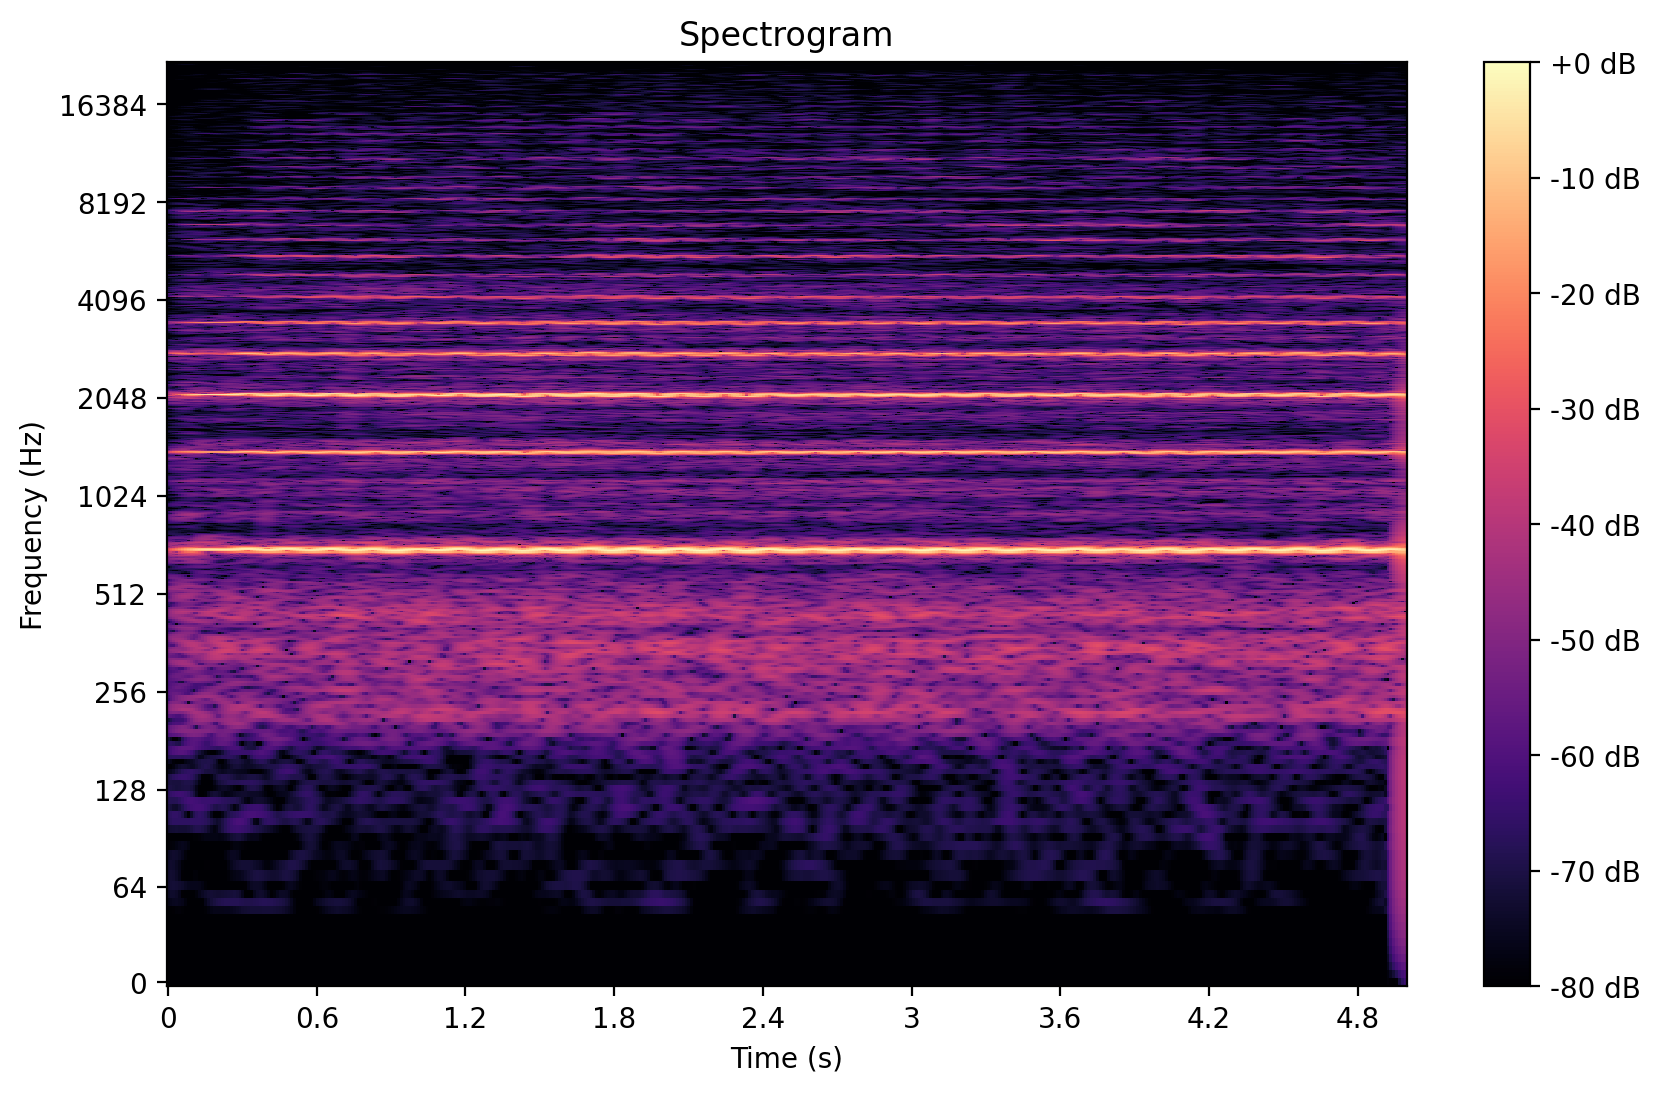

In [6]:

for batch_idx, data in enumerate(train_dl):
    #print(data)
    AudioUtil.plot_spectrogram(data[0])
    break

In [7]:
#(128x215 and 430x128)
#new (101x2 and 1103x128)

# Config for VAE xdim=413, hiddendim=1025, latent_dim=20, lr=0.00005, epochs=30, batch_size=1

x_dim  = 431
hidden_dim = 1025
latent_dim = 20

lr = 0.00005
#lr = 1e-3
epochs = 100

#encoder = model.Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
#decoder = model.Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = x_dim)

model = vae_model.VAE(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim).to(device)

print(model)

VAE(
  (fc1): Linear(in_features=431, out_features=1025, bias=True)
  (fc21): Linear(in_features=1025, out_features=20, bias=True)
  (fc22): Linear(in_features=1025, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=1025, bias=True)
  (fc4): Linear(in_features=1025, out_features=431, bias=True)
)


In [8]:
def plot_spectrogram(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
  print(spec.shape)
  fig, axs = plt.subplots(1, 1)
  axs.set_title(title or 'Spectrogram (db)')
  axs.set_ylabel(ylabel)
  axs.set_xlabel('frame')
  im = axs.imshow(librosa.power_to_db(spec), origin='lower', aspect=aspect)
  if xmax:
    axs.set_xlim((0, xmax))
  fig.colorbar(im, ax=axs)
  plt.show(block=False)

def stft_for_reconstruction(x, fft_size, hopsamp):
    window = np.hanning(fft_size)
    fft_size = int(fft_size)
    hopsamp = int(hopsamp)
    return np.array([np.fft.rfft(window*x[i:i+fft_size])
                     for i in range(0, len(x)-fft_size, hopsamp)])


def istft_for_reconstruction(X, fft_size, hopsamp):
    fft_size = int(fft_size)
    hopsamp = int(hopsamp)
    window = np.hanning(fft_size)
    time_slices = X.shape[0]
    len_samples = int(time_slices*hopsamp + fft_size)
    x = np.zeros(len_samples)
    for n,i in enumerate(range(0, len(x)-fft_size, hopsamp)):
        x[i:i+fft_size] += window*np.real(np.fft.irfft(X[n]))
    return x
def reconstruct_signal_griffin_lim(magnitude_spectrogram, fft_size, hopsamp, iterations):
    time_slices = magnitude_spectrogram.shape[0]
    len_samples = int(time_slices*hopsamp + fft_size)
    # Initialize the reconstructed signal to noise.
    x_reconstruct = np.random.randn(len_samples)
    n = iterations # number of iterations of Griffin-Lim algorithm.
    rmse = []
    while n > 0:
        n -= 1
        reconstruction_spectrogram = stft_for_reconstruction(x_reconstruct, fft_size, hopsamp)
        reconstruction_angle = np.angle(reconstruction_spectrogram)
        # Discard magnitude part of the reconstruction and use the supplied magnitude spectrogram instead.
        proposal_spectrogram = magnitude_spectrogram*np.exp(1.0j*reconstruction_angle)
        prev_x = x_reconstruct
        x_reconstruct = istft_for_reconstruction(proposal_spectrogram, fft_size, hopsamp)
        diff = np.sqrt(sum((x_reconstruct - prev_x)**2)/x_reconstruct.size)
        rmse.append(diff)
    return x_reconstruct, rmse

In [9]:

# The training function for early stopping runs but the 100 epochs 

log_interval = 10

optimizer = Adam(model.parameters(), lr=lr)

# L1 works like a charm
criterion = nn.L1Loss()

def train_es(epochs, patience = 10):

    # Writer will output to ./runs/ directory by default
    logdir = './runs/l1_es_ ' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    writer = SummaryWriter(logdir)

    early_stopping = EarlyStopping(patience=patience, verbose=True)

    for epoch in range(1, epochs + 1):

        model.train()
        train_loss = 0

        for batch_idx, spectrogram in enumerate(train_dl):

            #scipy works with cpu when applying the highpass filter
            float32_tensor = spectrogram[0].to(dtype=torch.float32)
            data = float32_tensor.to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            
            # recon_batch is prediction, data is ground_truth        
            #criterion is for l1 or mse
            loss = criterion(recon_batch, data)
            
            loss.backward()

            train_loss += loss.item()
            writer.add_scalar('Loss/train', train_loss, epoch)
            optimizer.step()
            if batch_idx % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_dl.dataset),
                    100. * batch_idx / len(train_dl),
                    loss.item() / len(data)))

        print('====> Epoch: {} Average loss: {:.4f}'.format(
            epoch, train_loss / len(train_dl.dataset)))

        # Validation
        model.eval()
        val_loss = 0

        with torch.no_grad():

            for i, spectrogram in enumerate(val_dl):
                float32_tensor = spectrogram[0].to(dtype=torch.float32)
                data = float32_tensor.to(device)

                recon_batch, mu, logvar = model(data)
                
                val_loss += criterion(recon_batch, data) #.item()
                #spec = recon_batch.squeeze().cpu().numpy()

                #AudioUtil.plot_spectrogram(spec)

                #x_rec, rmse = reconstruct_signal_griffin_lim(mag_subset.T, 2048, 512, 30)
                #x_rec, rmse = reconstruct_signal_griffin_lim(spec.T, 2048, 512, 30)            

                #sf.write(f'./reconstructed_violin_high_pass/test_reconst_{i}.wav', x_rec, 44100)
                
                #sf.write(f'./reconstructed_accordion/test_reconst_{i}.wav', x_rec, 44100)

        #val_loss /= len(val_dl.dataset)

        # Calculate average losses
        train_loss /= len(train_dl.dataset)
        val_loss /= len(val_dl.dataset)
        
        print('====> Test set loss: {:.4f}'.format(val_loss))

        early_stopping(val_loss)

        if early_stopping.early_stop:
            print("Early stopping")
            break

    writer.close()



In [ ]:
# regular training function
# This function doesn't implement early stopping
# The dataset returns each spectrogram after applying a highpass filter

log_interval = 10

optimizer = Adam(model.parameters(), lr=lr)

# L1 works like a charm
criterion = nn.L1Loss()

def train(epochs):
    model.train()
    train_loss = 0

    # Writer will output to ./runs/ directory by default
    logdir = './runs/l1_short_window_ ' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    writer = SummaryWriter(logdir)

    for epoch in range(1, epochs + 1):
        for batch_idx, spectrogram in enumerate(train_dl):

            #scipy works with cpu when applying the highpass filter
            float32_tensor = spectrogram[0].to(dtype=torch.float32)
            data = float32_tensor.to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            
            # recon_batch is prediction, data is ground_truth        
            #criterion is for l1 or mse
            loss = criterion(recon_batch, data)
            
            loss.backward()

            train_loss += loss.item()
            writer.add_scalar('Loss/train', train_loss, epoch)
            optimizer.step()
            if batch_idx % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_dl.dataset),
                    100. * batch_idx / len(train_dl),
                    loss.item() / len(data)))

        print('====> Epoch: {} Average loss: {:.4f}'.format(
            epoch, train_loss / len(train_dl.dataset)))

    writer.close()

In [10]:
#train(epochs)

patience = 3
#patience = 10
#epochs = 100
train_es(epochs, patience)


/Users/diegofreire/anaconda3/lib/python3.10/site-packages/torch/autograd/__init__.py:251: UserWarning: The operator 'aten::sgn.out' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400234613/work/aten/src/ATen/mps/MPSFallback.mm:13.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Train Epoch: 1 [0/364 (0%)]	Loss: 0.000125
Train Epoch: 1 [40970/364 (3%)]	Loss: 0.000113
Train Epoch: 1 [81940/364 (5%)]	Loss: 0.000142
Train Epoch: 1 [122910/364 (8%)]	Loss: 0.000100
Train Epoch: 1 [163880/364 (11%)]	Loss: 0.000094
Train Epoch: 1 [204850/364 (14%)]	Loss: 0.000091
Train Epoch: 1 [245820/364 (16%)]	Loss: 0.000083
Train Epoch: 1 [286790/364 (19%)]	Loss: 0.000111
Train Epoch: 1 [327760/364 (22%)]	Loss: 0.000067
Train Epoch: 1 [368730/364 (25%)]	Loss: 0.000064
Train Epoch: 1 [409700/364 (27%)]	Loss: 0.000055
Train Epoch: 1 [450670/364 (30%)]	Loss: 0.000049
Train Epoch: 1 [491640/364 (33%)]	Loss: 0.000050
Train Epoch: 1 [532610/364 (36%)]	Loss: 0.000081
Train Epoch: 1 [573580/364 (38%)]	Loss: 0.000039
Train Epoch: 1 [614550/364 (41%)]	Loss: 0.000039
Train Epoch: 1 [655520/364 (44%)]	Loss: 0.000040
Train Epoch: 1 [696490/364 (47%)]	Loss: 0.000027
Train Epoch: 1 [737460/364 (49%)]	Loss: 0.000066
Train Epoch: 1 [778430/364 (52%)]	Loss: 0.000025
Train Epoch: 1 [819400/364 (55%

In [13]:
def test(epoch,val_dl):
    model.eval()
    test_loss = 0

    with torch.no_grad():
        for i, spectrogram in enumerate(val_dl):
            float32_tensor = spectrogram[0].to(dtype=torch.float32)
            data = float32_tensor.to(device)

            recon_batch, mu, logvar = model(data)
            
            test_loss += criterion(recon_batch, data) #.item()
            spec = recon_batch.squeeze().cpu().numpy()

            AudioUtil.plot_spectrogram(spec)

            #x_rec, rmse = reconstruct_signal_griffin_lim(mag_subset.T, 2048, 512, 30)
            #x_rec, rmse = reconstruct_signal_griffin_lim(spec.T, 2048, 512, 30)            

            #x_rec, rmse = reconstruct_signal_griffin_lim(spec.T, 8192, 512, 30)            
            #x_rec, rmse = reconstruct_signal_griffin_lim(spec.T, 8192, 512, 30)            


            #sf.write(f'./reconstructed_accordion/test_reconst_{i}.wav', x_rec, 44100)
            #sf.write(f'./reconstructed_string_accordion_val/test_reconst_{i}.wav', x_rec, 44100)

    test_loss /= len(val_dl.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))


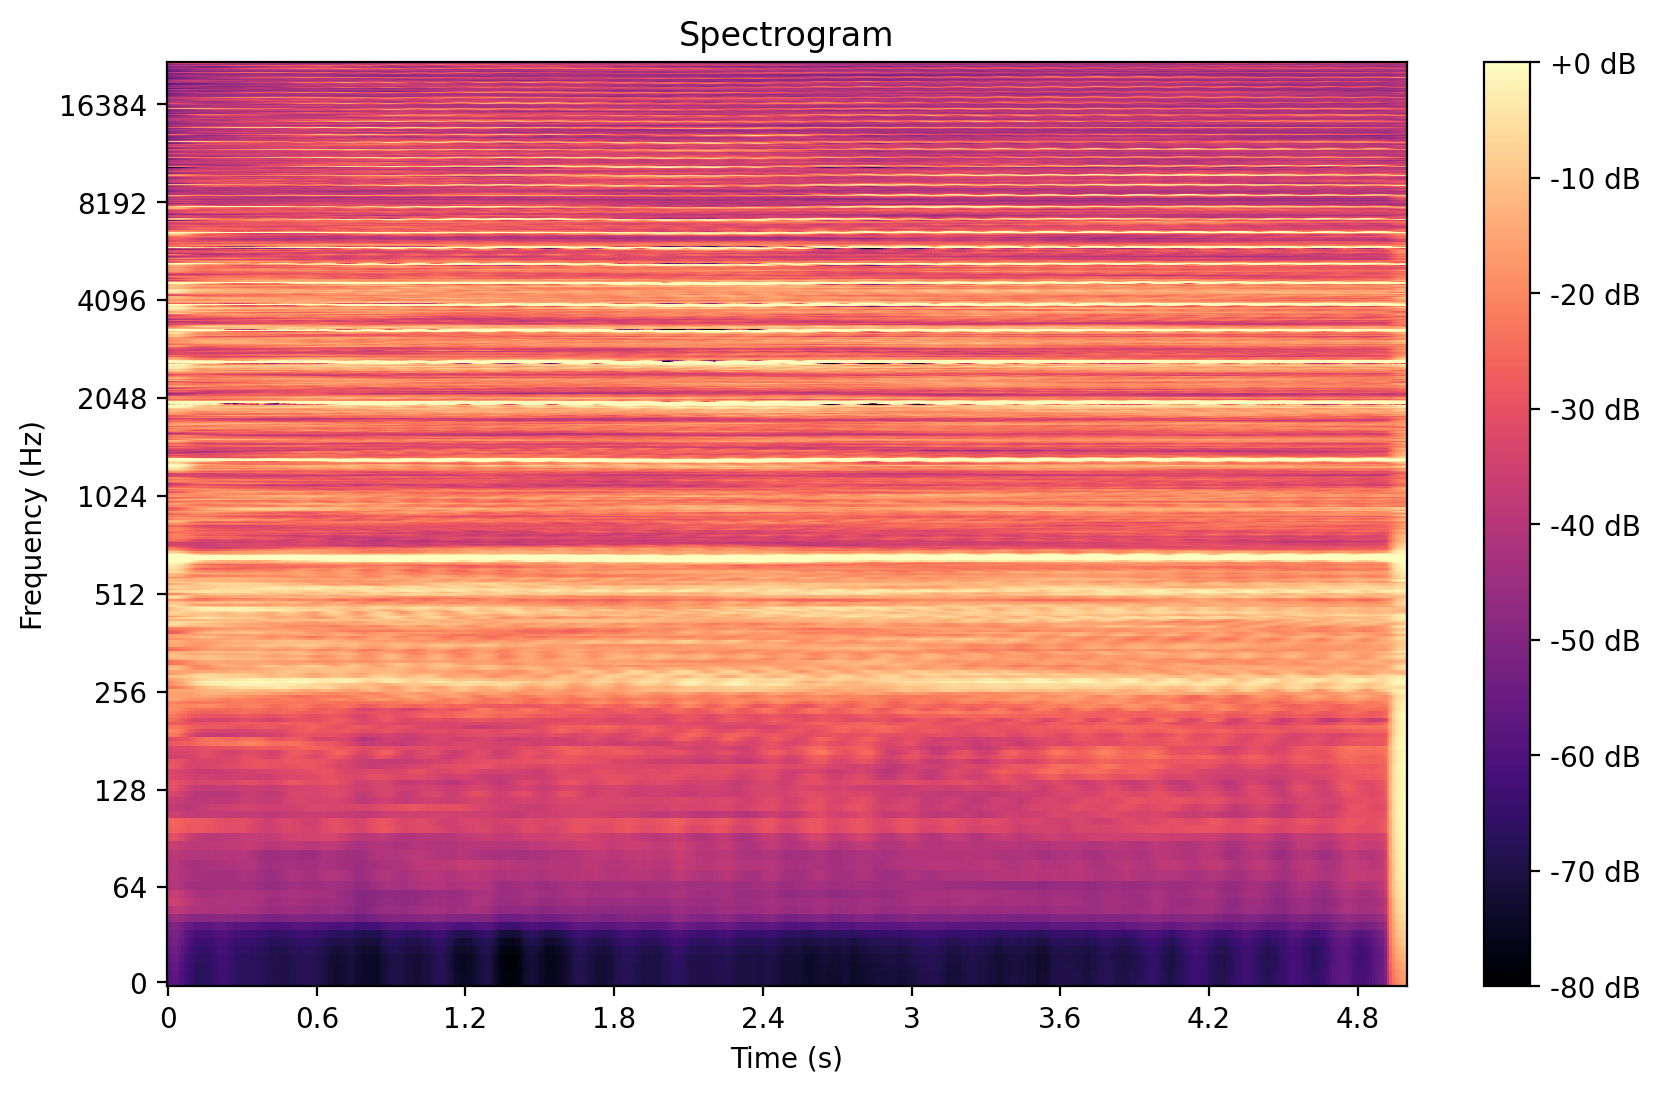

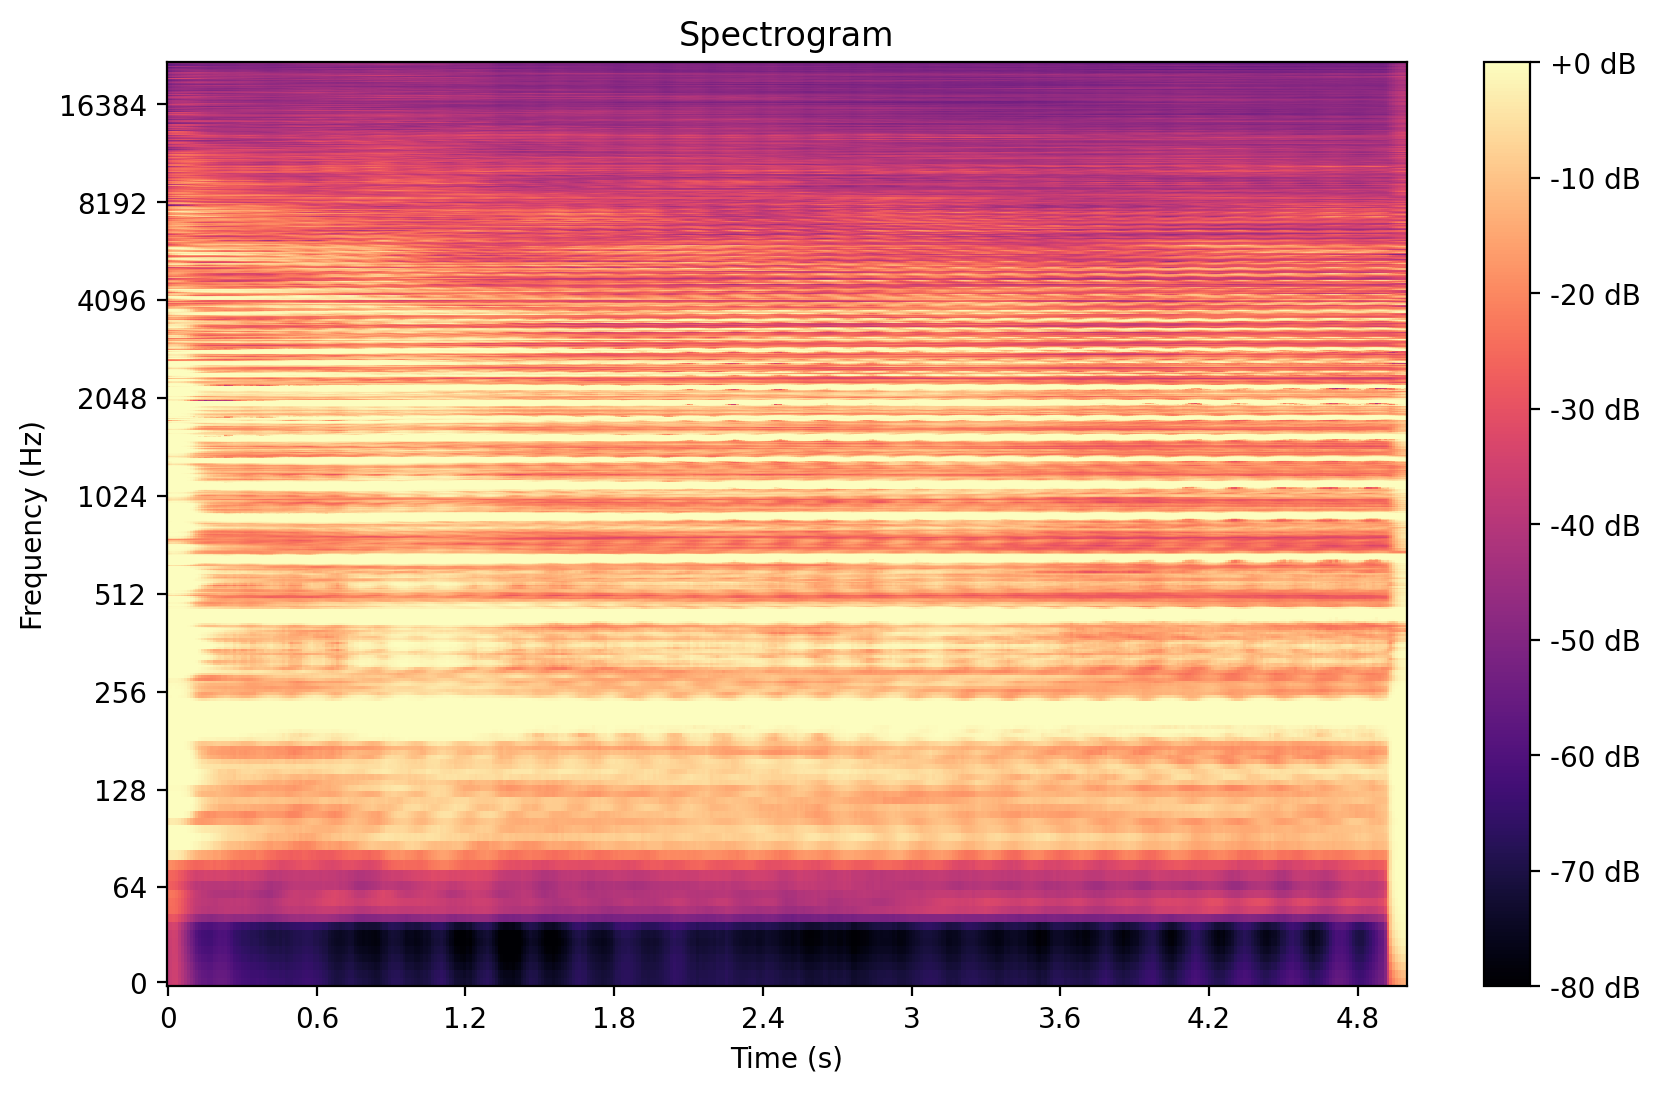

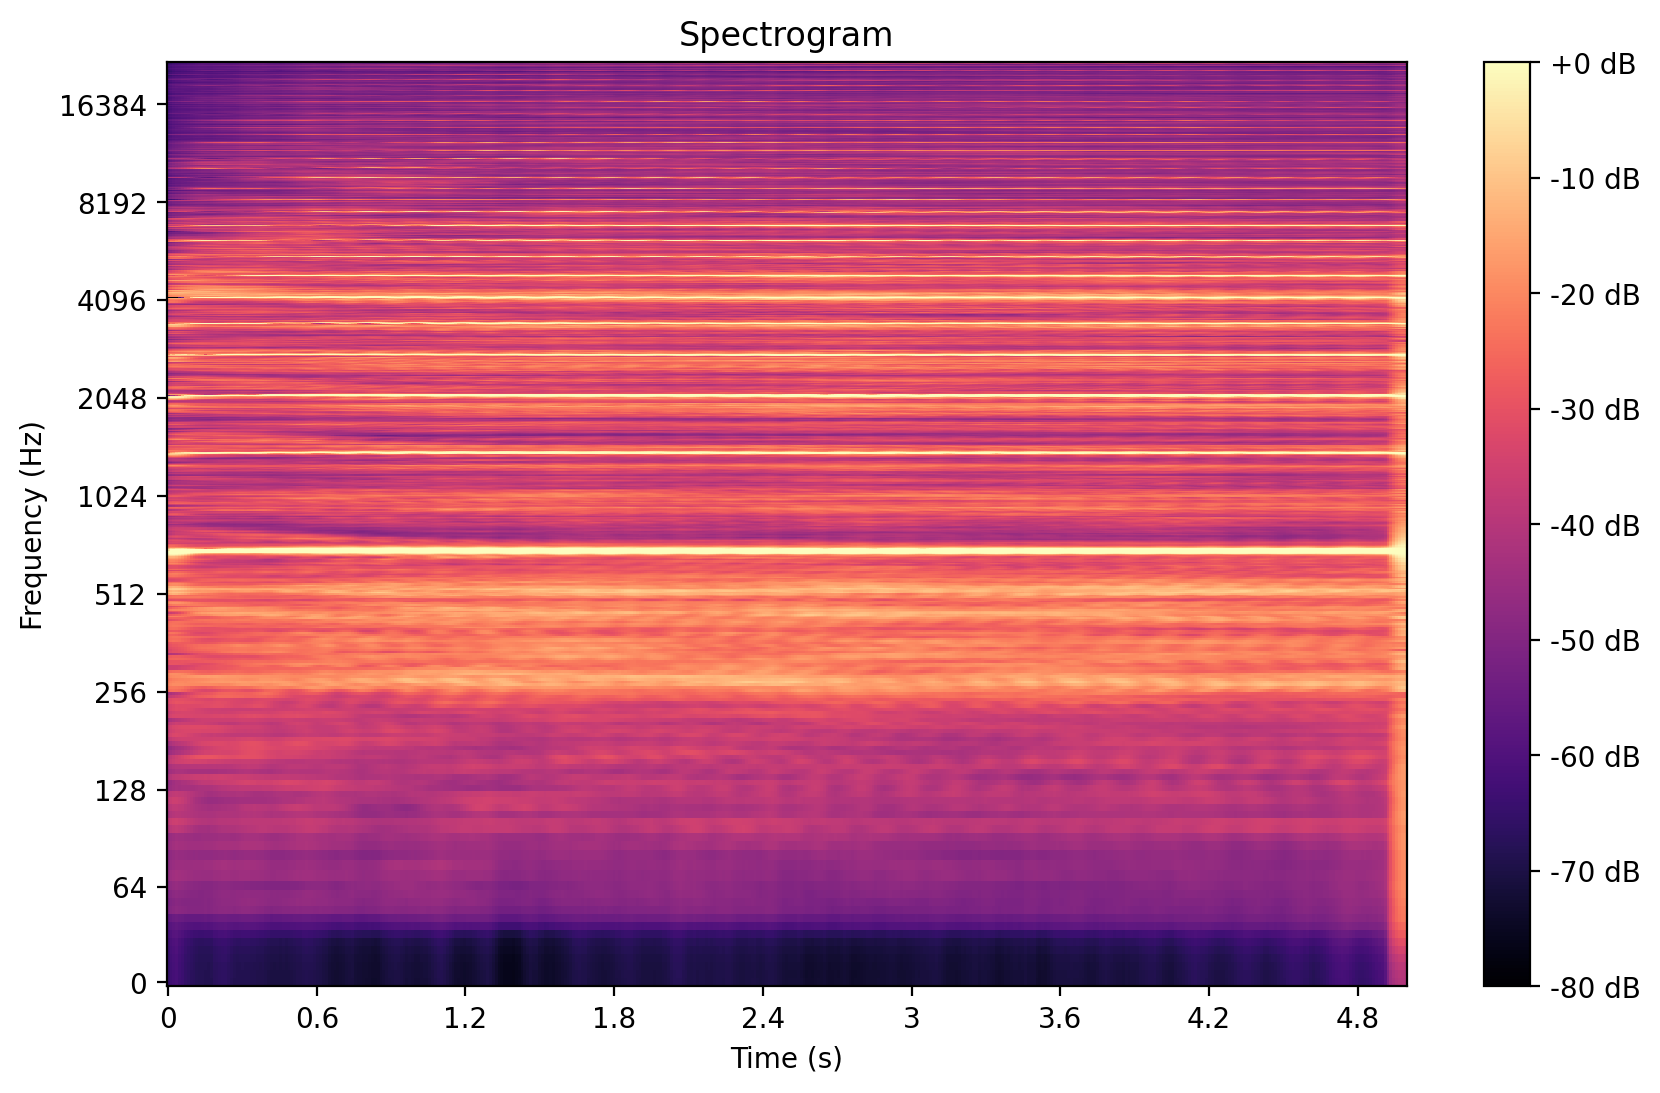

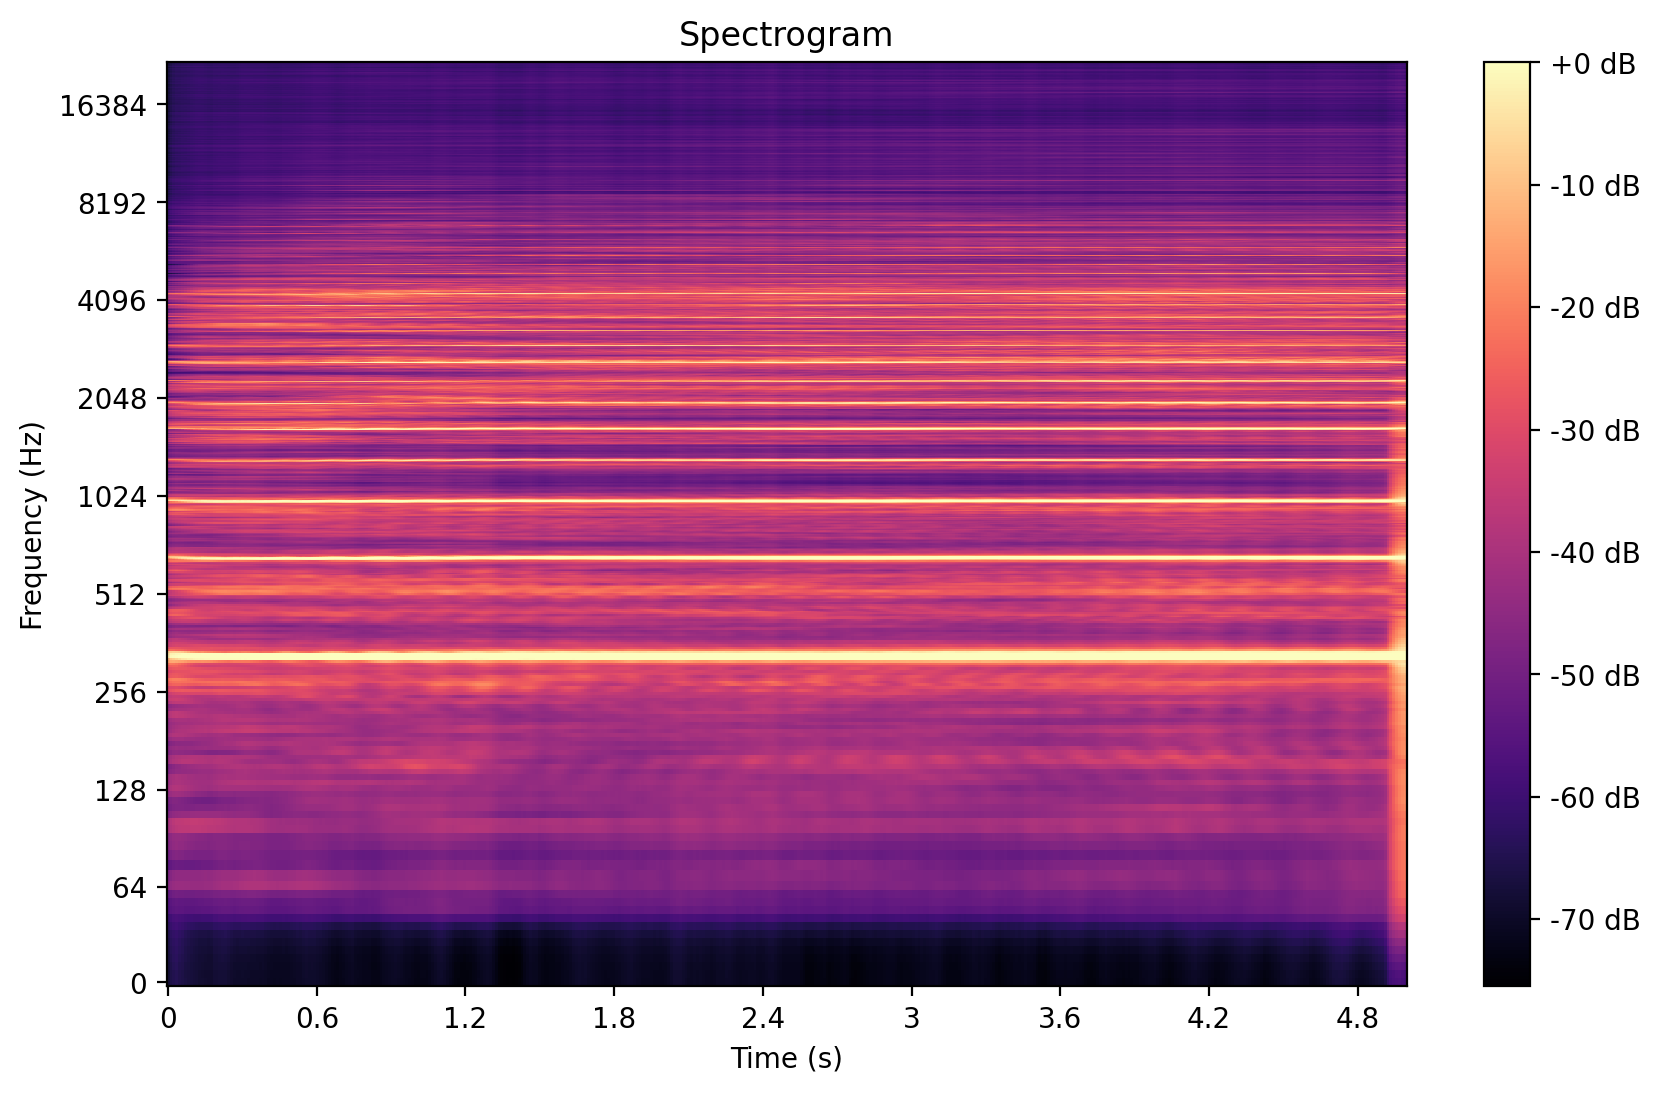

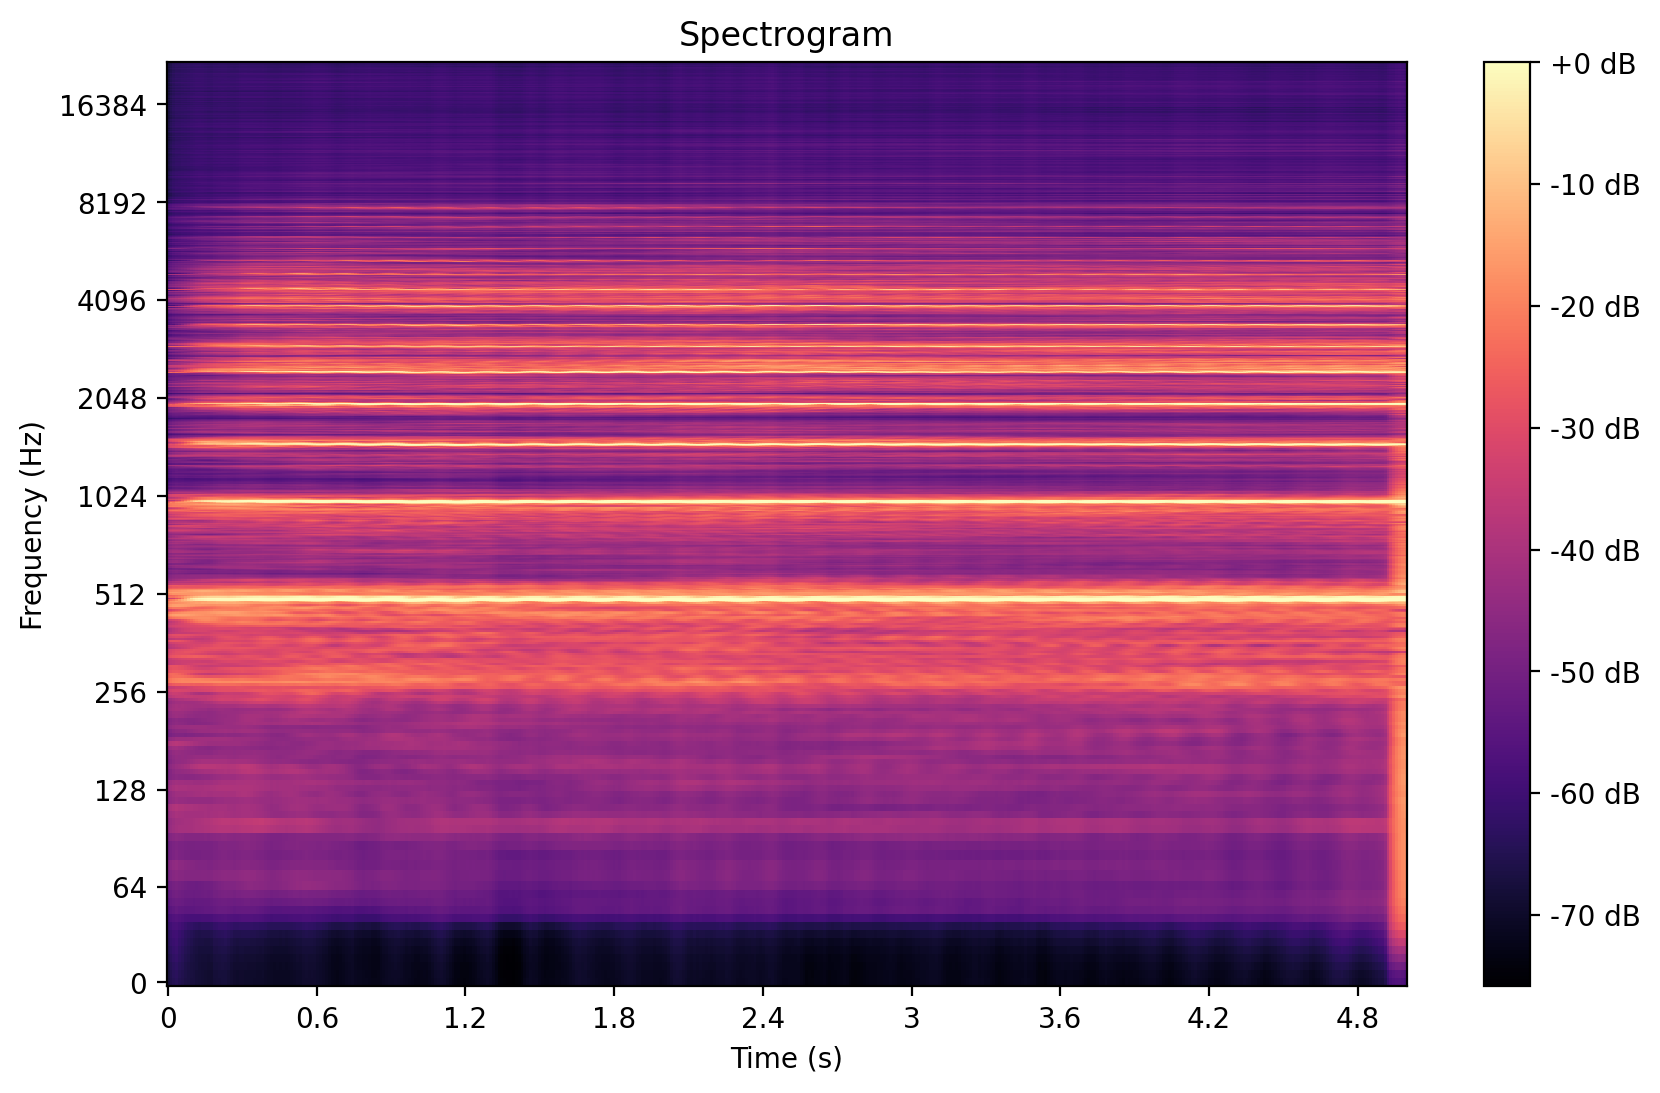

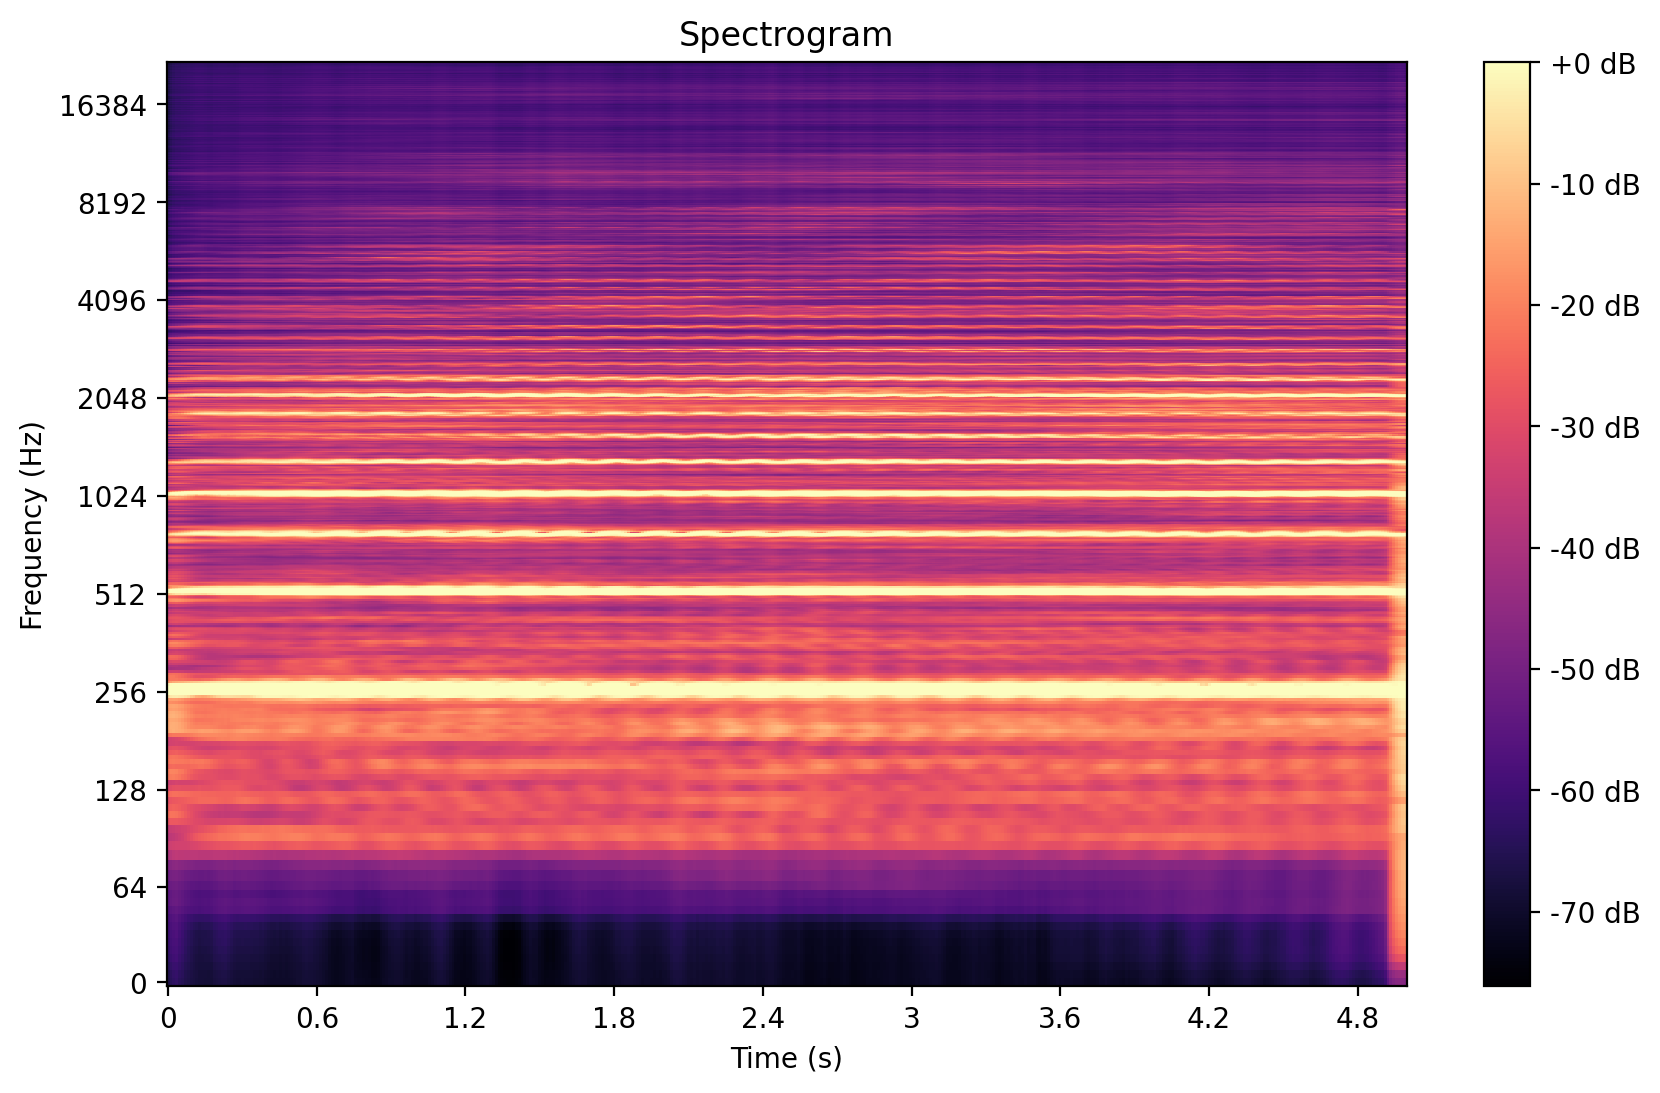

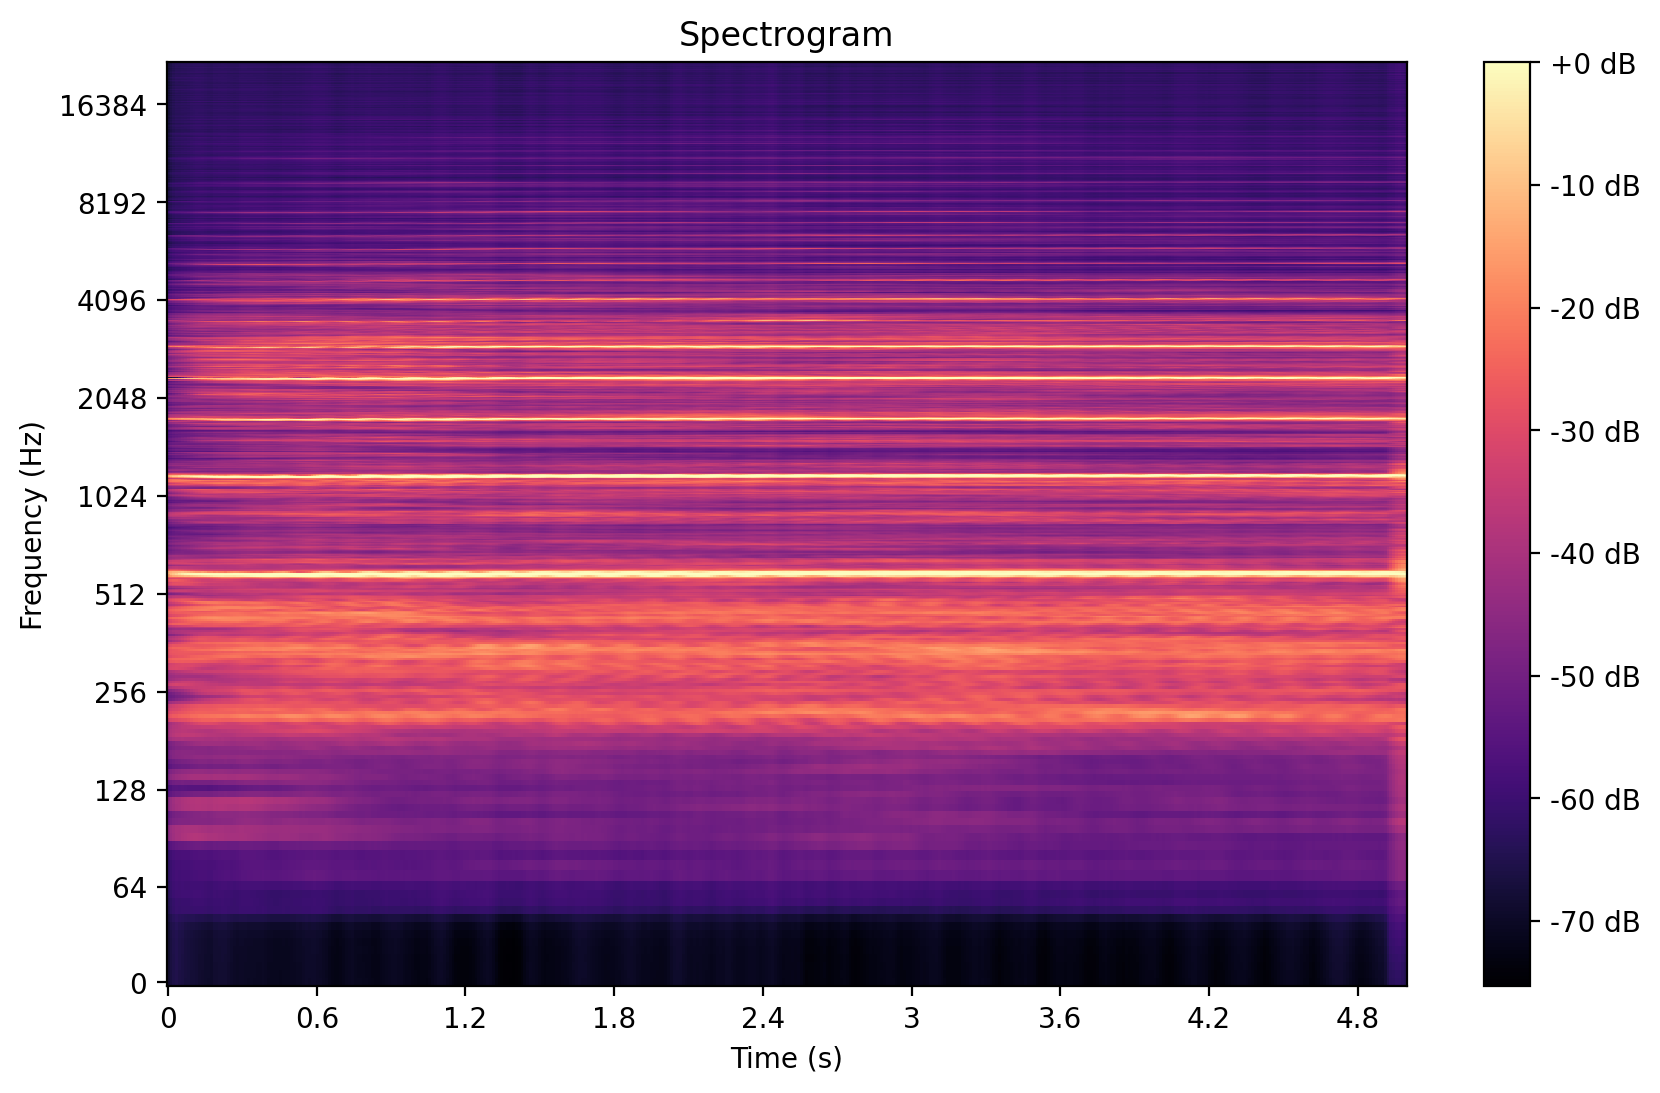

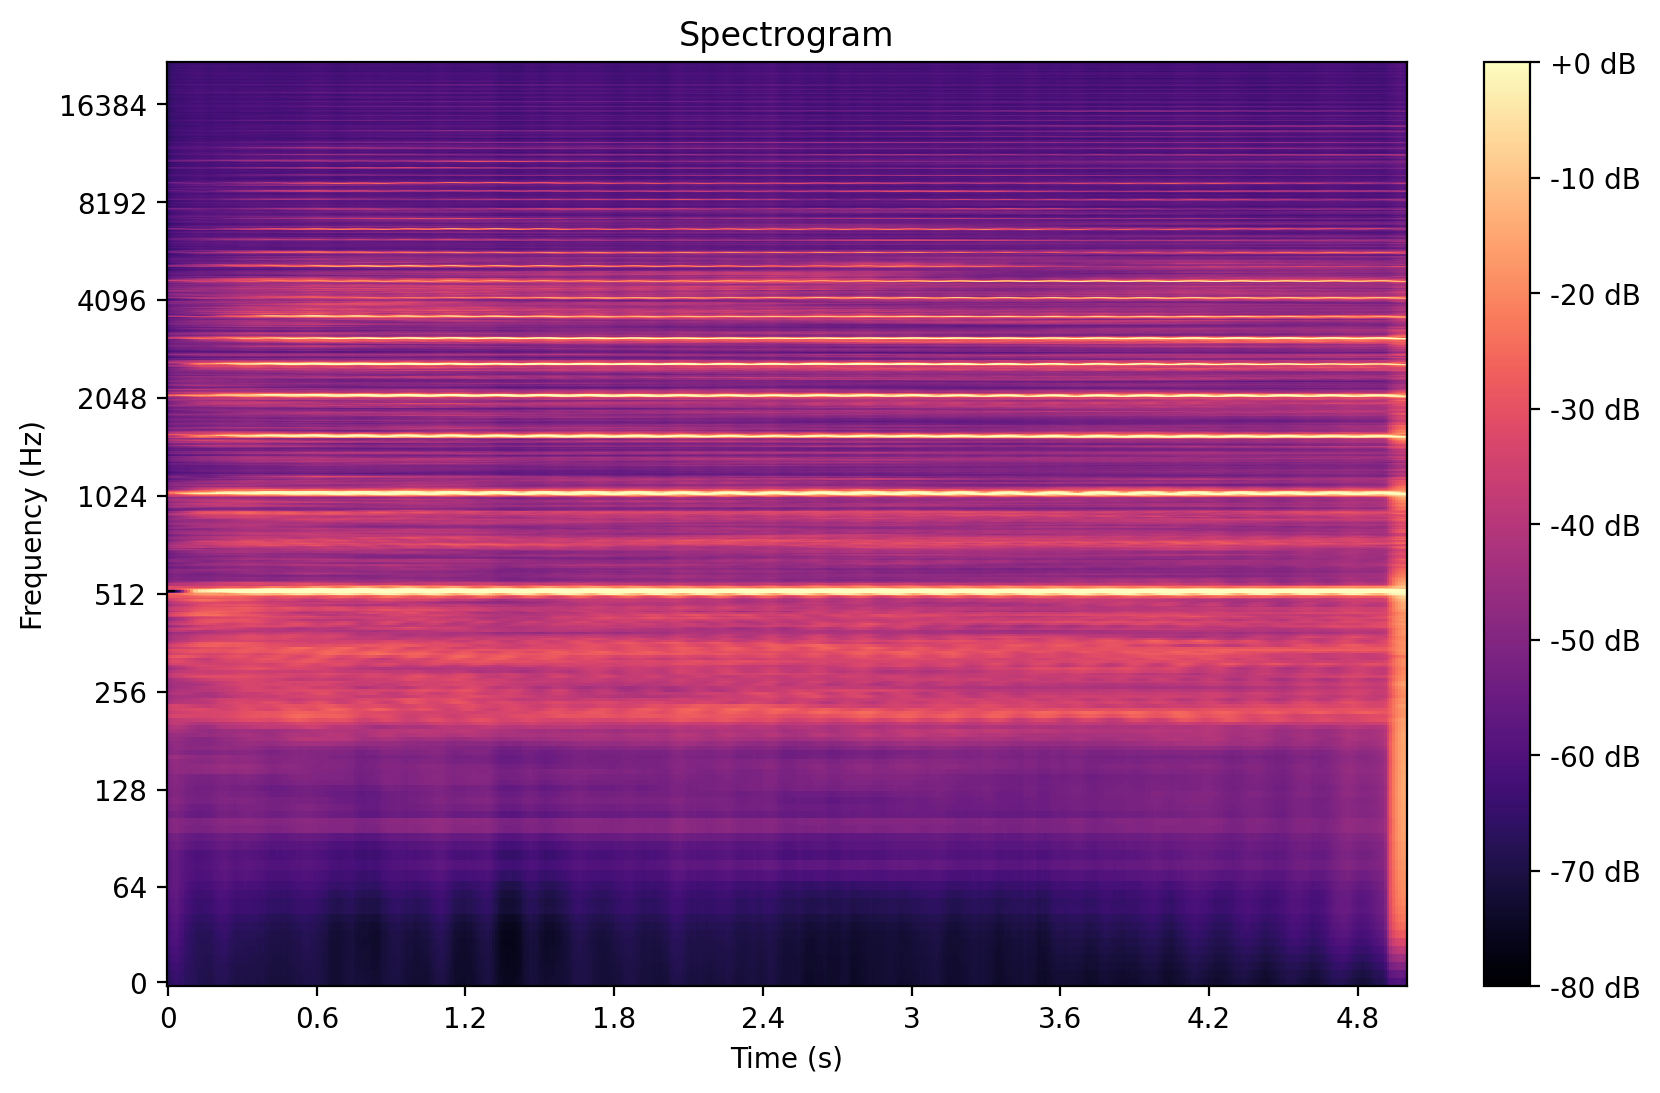

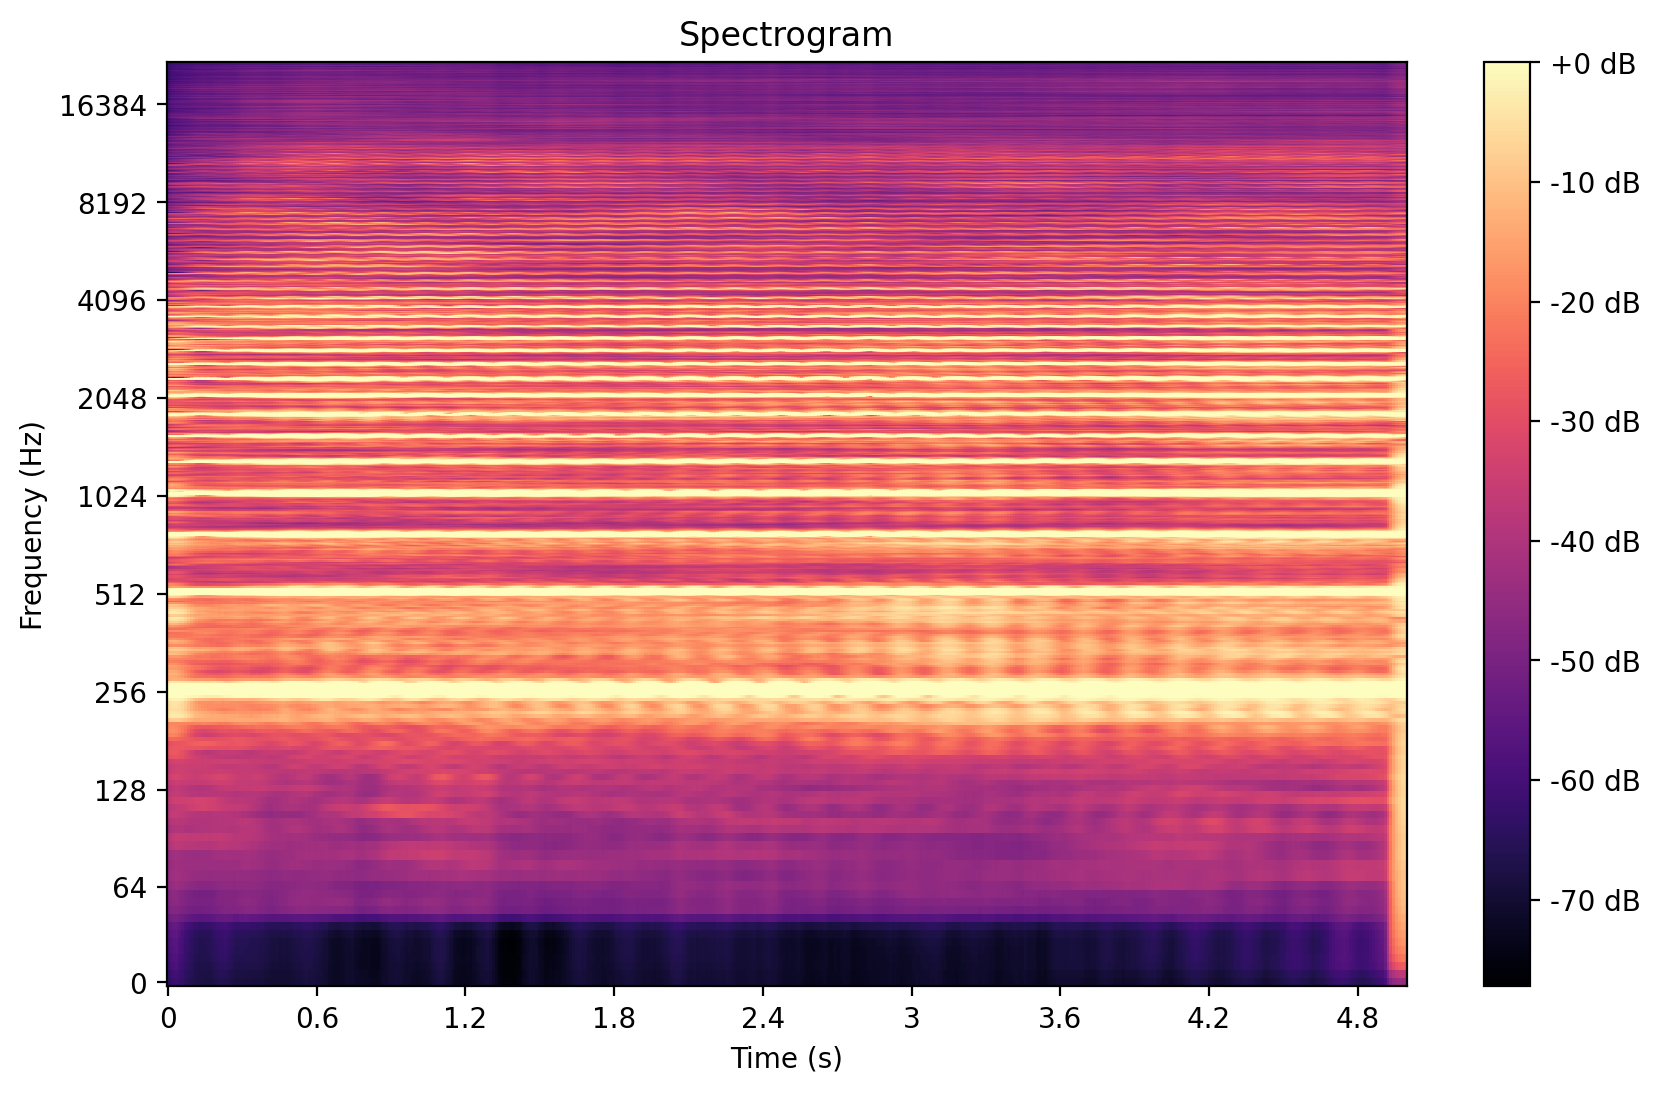

KeyboardInterrupt: 

In [14]:
for epoch in range(1, epochs + 1):
    test(epoch,exp_val_dl)

In [ ]:

def griffin_lim(magnitude_spectrogram, iterations=30, n_fft=1024, hop_length=None, win_length=None, length=None):
    """
    Implements the Griffin-Lim algorithm to estimate the phase given only the magnitude
    of the Short-Time Fourier Transform (STFT).

    Args:
    magnitude_spectrogram (torch.Tensor): Magnitude spectrogram
    [..]
    Returns:
    torch.Tensor: Reconstructed time-domain signal
    """

    # Randomly initialize
    phase = torch.exp(2j * torch.pi * torch.rand_like(magnitude_spectrogram))
    complex_spectrogram = magnitude_spectrogram * phase

    # Window function for the STFT/ISTFT
    window = torch.hann_window(win_length)

    for _ in range(iterations):
        # Inverse STFT
        signal = torch.istft(complex_spectrogram, n_fft=n_fft, hop_length=hop_length, win_length=win_length, window=window, length=length)

        # Re-calculate STFT with return_complex=True
        recomplex_spectrogram = torch.stft(signal, n_fft=n_fft, hop_length=hop_length, win_length=win_length, window=window, return_complex=True)

        # Update only the phase
        _, phase = torch.abs(recomplex_spectrogram), torch.angle(recomplex_spectrogram)
        complex_spectrogram = magnitude_spectrogram * torch.exp(1j * phase)

    # Final iSTFT to get the time domain signal
    signal = torch.istft(complex_spectrogram, n_fft=n_fft, hop_length=hop_length, win_length=win_length, window=window, length=length)
    
    return signal

#for epoch in range(1, epochs + 1):
#   train(epoch)
    #test(epoch)

    # random sampling to generate new sounds doesn't work yet.

#fft_size, hop_size, win_size, mel_size,
#sample_rate=24000,
#preemphasis=0.97,
#normalized=False,
#ref_level_db=20,
#min_level_db=-115
#griffin_lim = T.GriffinLim(n_fft=128, win_length=128, hop_length=128 )


#x_dim  = 431
#hidden_dim = 1025
#latent_dim = 20


with torch.no_grad():
    

    sample = torch.randn(1,latent_dim,).to(device)
    #filename = './../wav/Acc-ord-A3-ff-alt1-N.wav'
    #waveform, spect = AudioUtil.load_and_process_audio(filename,sr=44100, duration=5)

    #print(spect.shape)
    #spectrogram_tensor = torch.from_numpy(spect.astype(np.float32)).to(device)

    spec = model.decode(sample).cpu()

    x_rec, rmse = reconstruct_signal_griffin_lim(spec.numpy().T, 2048, 512, 30)

    print(spec.shape)

    #reconstructed_audio = griffin_lim(
    #    spec.squeeze(), 
    #    iterations=30, 
    #    n_fft=2048, 
    #    hop_length=512, 
    #    win_length=2205
    #)

    sf.write('test_reconst.wav', x_rec, 44100)

    #print(spec)

    #waveform = griffin_lim(spec)
    
    #spec.view(1,1,128,430)

    # while trainin, the shape of the spec is aug_sgram: torch.Size([1, 128, 430])

    #batch_size,channels,dimension1,dimension2

    #y_inv_32 = librosa.griffinlim_cqt(spec.view(-1,430),n_fft=2048, hop_length=hop_len, dtype=np.float32)

    #sf.write('test_reconst.wav', y_inv_32, 22050)


        


In [ ]:
#model_scripted = torch.jit.script(model) # Export to TorchScript
#model_scripted.save('VAE_violin_epc100_L1loss.pt') # Save

#VAE doesn't work
#VAE_org works

In [ ]:
#model = torch.jit.load('VAE_org.pt')
#model.eval()

In [ ]:
#import umap